In [1]:
import xarray as xr
import numpy as np

# Load saved results

In [2]:
def preprocess(ds):
    ds = ds.rename({'Duration':'duration','Gamma':'gamma','Tp':'tp','Seed':'seed'})
    ds = ds.assign_coords({'duration':ds['duration'],'gamma':ds['gamma'],'tp':ds['tp'],'seed':range(len(ds['seed']))})
    return ds

datasets = {'RAS':'RAS_n10000_2Hz.zarr',
            'RAS_FR':'RAS_n10000_2Hz_fixedres.zarr',
            'DAS':'DAS_n10000_2Hz.zarr',
            'DAS_FR':'DAS_n10000_2Hz_fixedres.zarr'}

dsets = [preprocess(xr.open_zarr(f'data/timeseries_stats/{fn}')) for fn in datasets.values()]
ds = xr.concat(dsets,dim=xr.DataArray(list(datasets.keys()),dims='mthd'))

ds['HmHs'] = ds['Hmax']/ds['Hs']
ds_std = ds.std(dim='seed')
ds_mean = ds.mean(dim='seed')
ds_max = ds.max(dim='seed')
ds_CV = ds_std/ds_mean
ds_CV

<xarray.Dataset>
Dimensions:    (duration: 6, gamma: 12, tp: 25, mthd: 4)
Coordinates:
  * duration   (duration) int32 120 300 600 1200 2400 3600
  * gamma      (gamma) float64 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5
  * tp         (tp) float64 8.0 8.5 9.0 9.5 10.0 ... 18.0 18.5 19.0 19.5 20.0
  * mthd       (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
Data variables:
    H13        (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    Hmax       (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    Hs         (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    Tz         (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    r          (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    this_seed  (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>
    HmHs       (mthd, tp, gamma, duration) float64 dask.array<chunksize=(1, 25, 12, 1), meta=np.ndarray>

## Examine distribution of parameters averaged across Tp and Gamma

In [3]:
import seaborn as sns
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt

In [4]:
ds_stacked = ds.isel(seed=slice(0,1000)).stack(sample=['tp','gamma','seed'])
ds_stacked

<xarray.Dataset>
Dimensions:    (duration: 6, mthd: 4, sample: 300000)
Coordinates:
  * duration   (duration) int32 120 300 600 1200 2400 3600
  * mthd       (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
  * sample     (sample) MultiIndex
  - tp         (sample) float64 8.0 8.0 8.0 8.0 8.0 ... 20.0 20.0 20.0 20.0 20.0
  - gamma      (sample) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 6.5 6.5 6.5 6.5 6.5
  - seed       (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    H13        (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    Hmax       (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    Hs         (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    Tz         (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    r          (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    this_seed  (mthd, duration, sample) int32 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>
    HmHs       (mthd, duration, sample) float64 dask.array<chunksize=(1, 1, 300000), meta=np.ndarray>

In [5]:
import warnings
warnings.filterwarnings('ignore')

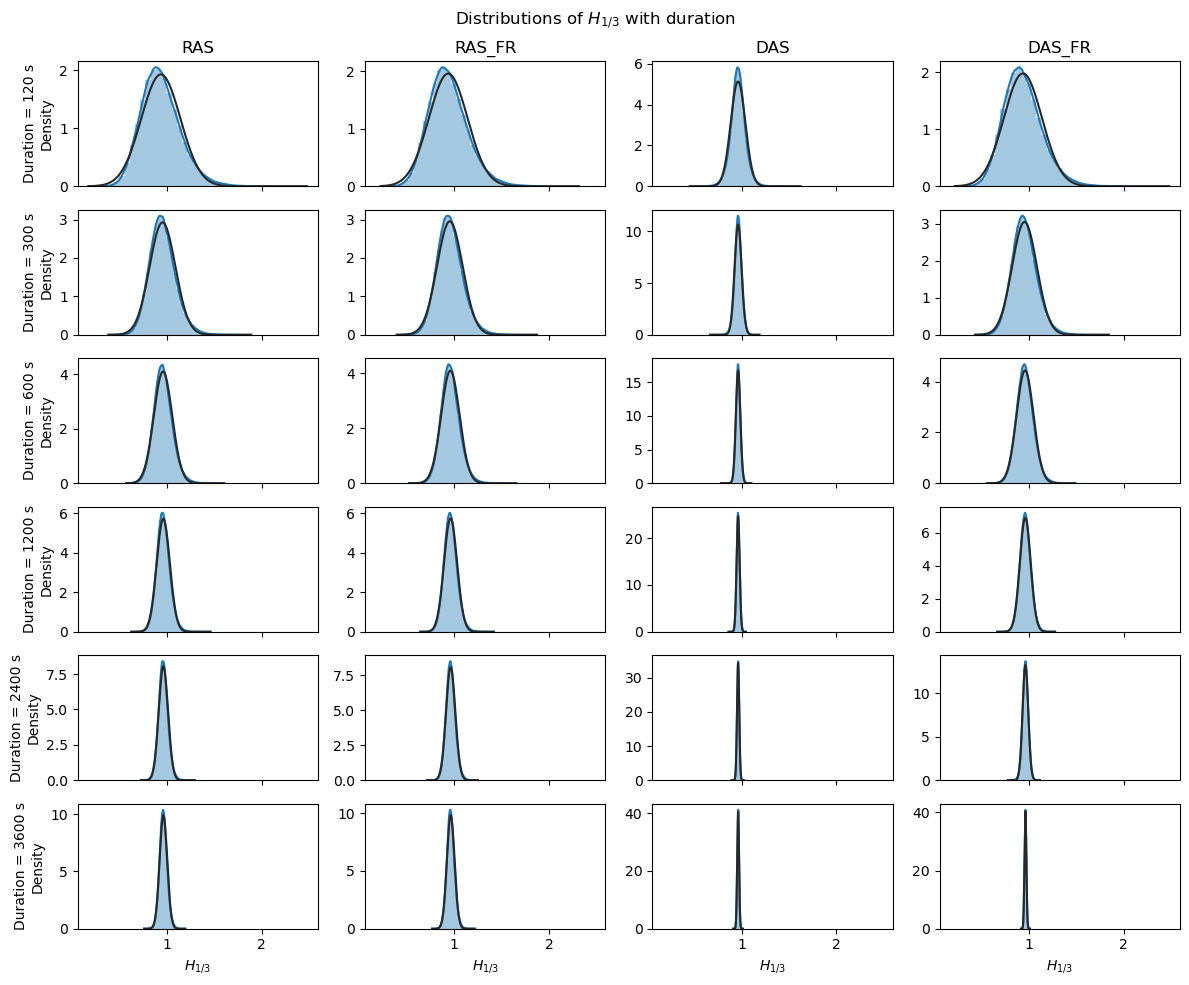

In [6]:
def distplot(ds_stacked,v,label):
    fig,axs = plt.subplots(len(ds_stacked.duration),len(ds_stacked.mthd),figsize=(12,10),sharex=True)
    for i,d in enumerate(ds_stacked.duration):
        for j,m in enumerate(ds_stacked.mthd):
            m = m.values
            ax = axs[i,j]
            data = ds_stacked[v].sel(duration=d,mthd=m)
            sns.distplot(data,ax = ax,fit=norm,hist=True,bins=40)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('')

    for j,m in enumerate(ds_stacked.mthd):
        axs[0,j].set_title(f'{m.values}')     
        axs[-1,j].set_xlabel(f'${label}$')   
    for i,d in enumerate(ds_stacked.duration):
        axs[i,0].set_ylabel(f'Duration = {d.values} s\nDensity')


    fig.suptitle(f'Distributions of ${label}$ with duration')
    fig.tight_layout()
    return fig,axs
    
fig,axs = distplot(ds_stacked,'H13','H_{1/3}')

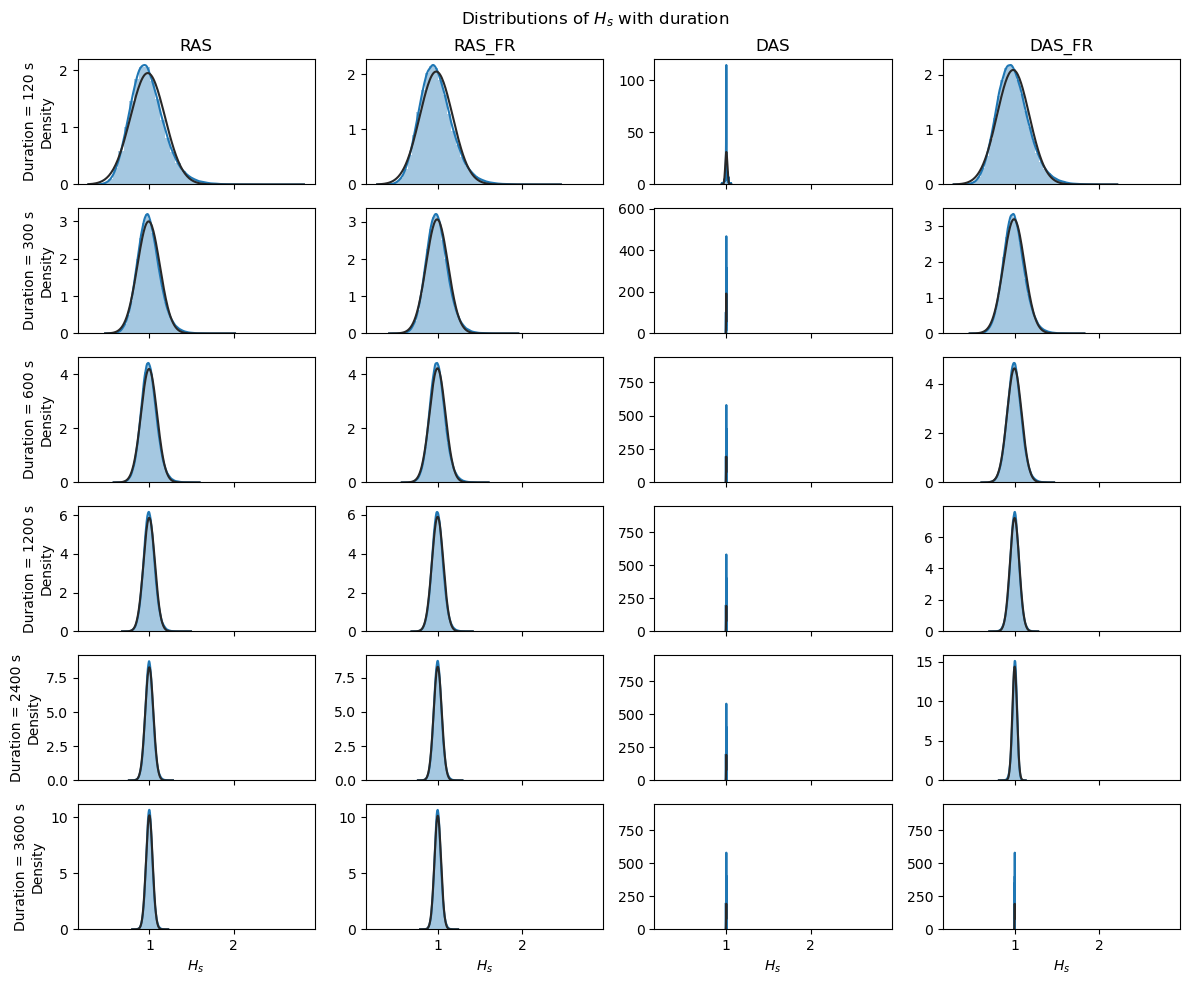

In [7]:
fig, axs = distplot(ds_stacked,'Hs','H_s')

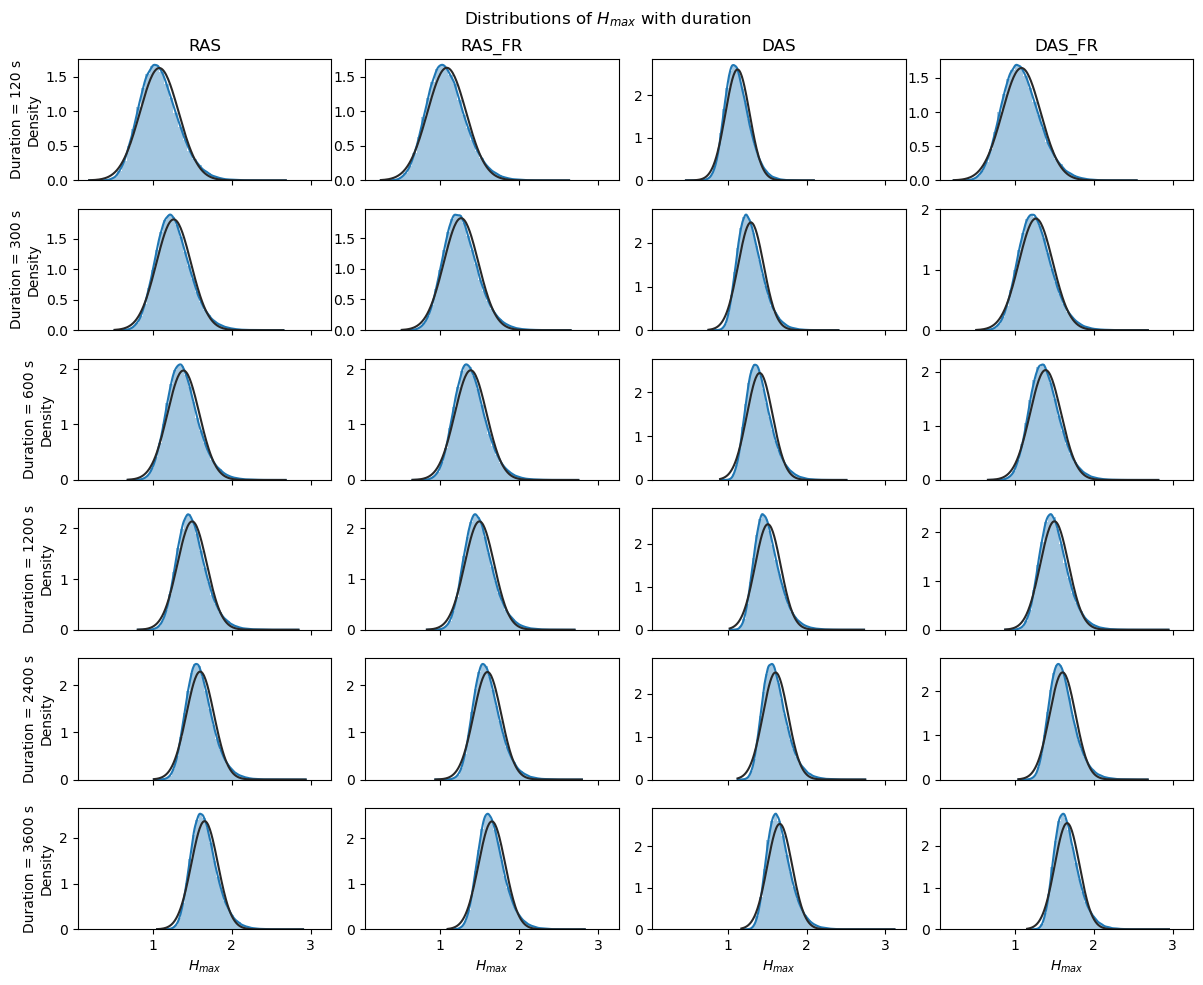

In [8]:
fig, axs = distplot(ds_stacked,'Hmax','H_{max}')

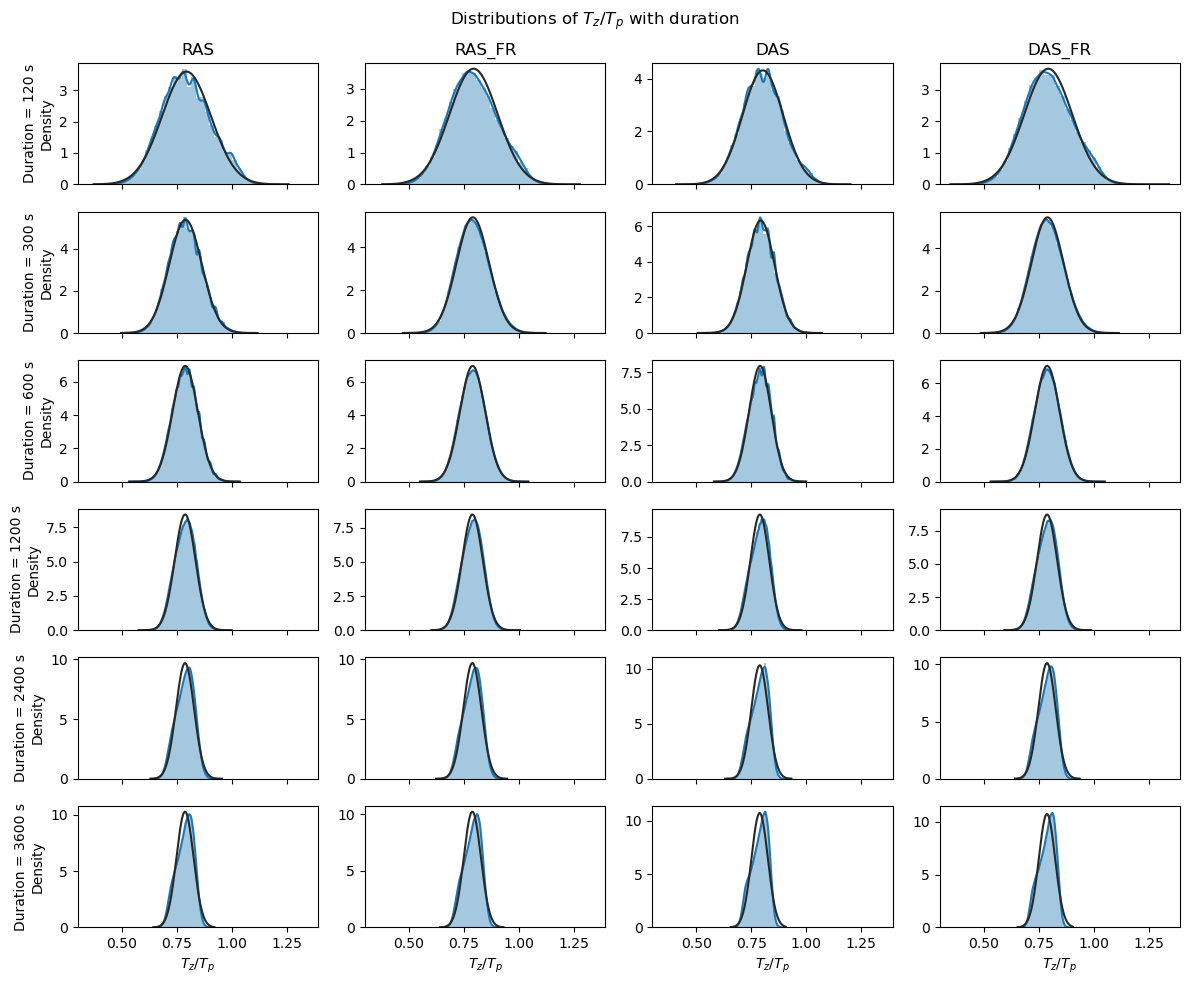

In [9]:
ds_stacked['TzTp'] = ds_stacked.Tz/ds_stacked.tp
fig, axs = distplot(ds_stacked,'TzTp','T_z/T_p')

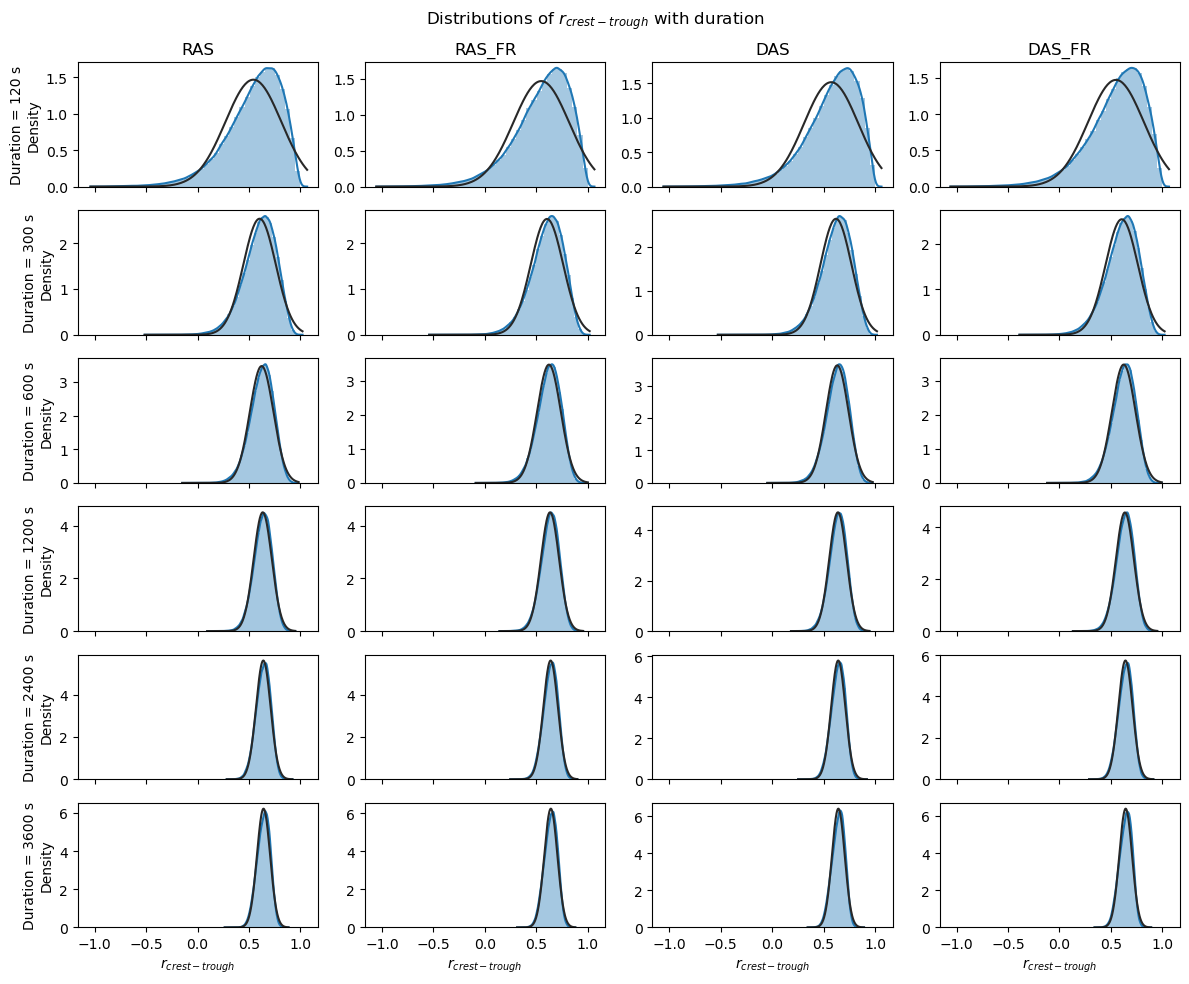

In [10]:
fig, axs = distplot(ds_stacked,'r','r_{crest-trough}')

In [11]:
ds_results_mean = ds.stack(sample=['tp','gamma','seed']).mean(dim='sample')
ds_results_std = ds.stack(sample=['tp','gamma','seed']).std(dim='sample')
ds_results = ds_results_std/ds_results_mean
ds_results = ds_results.drop('this_seed')
ds_results

<xarray.Dataset>
Dimensions:   (duration: 6, mthd: 4)
Coordinates:
  * duration  (duration) int32 120 300 600 1200 2400 3600
  * mthd      (mthd) <U6 'RAS' 'RAS_FR' 'DAS' 'DAS_FR'
Data variables:
    H13       (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Hmax      (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Hs        (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    Tz        (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    r         (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    HmHs      (mthd, duration) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

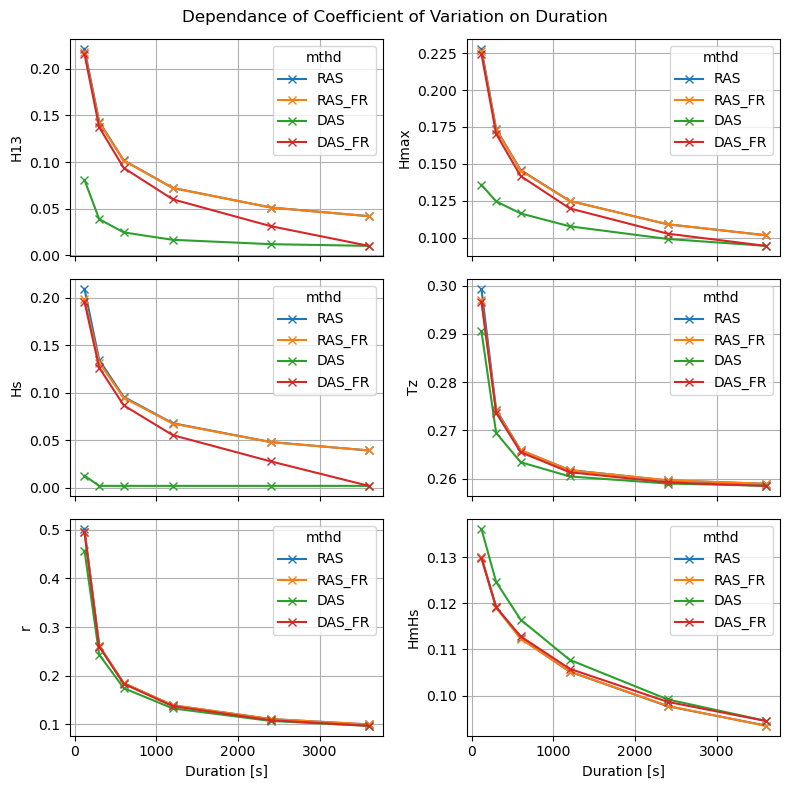

In [12]:
fig,axs = plt.subplots(3,2,sharex=True,figsize=(8,8))
axs = axs.ravel()

for i,v in enumerate(ds_results.data_vars):
    ax=axs[i]
    ds_results[v].plot(hue='mthd',ax=ax,marker='x')
    ax.grid('on')
    ax.set_xlabel('')

axs[-1].set_xlabel('Duration [s]')
axs[-2].set_xlabel('Duration [s]')
fig.suptitle('Dependance of Coefficient of Variation on Duration')
fig.tight_layout()
fig.savefig('figures/TimeseriesMethodComparison.png')